## Preface from mike

I modified the notebook from lab2 of the Berkley reinforcement bootcamp 2017 to run on google's colab. This save you from having to set up your own environment.

Make a copy of this notebook, (so you don't give everyone the answers). Click file=>make a copy

Run the first few cells to download the required code so you run it on a google cloud backend (for free for now). We can also share comments 

In [1]:
%%bash
echo "downloading lab"
wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B1BwaUH2mk-ELUVyUFFvVmcyUnM' -O lab2.zip

downloading lab


--2017-11-02 13:23:32--  https://docs.google.com/uc?export=download&id=0B1BwaUH2mk-ELUVyUFFvVmcyUnM
Resolving docs.google.com (docs.google.com)... 74.125.141.102, 74.125.141.101, 74.125.141.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.141.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/33ja8u79g6j11di8433ii8url0hpv5rk/1509624000000/16080780047704686699/*/0B1BwaUH2mk-ELUVyUFFvVmcyUnM?e=download [following]
--2017-11-02 13:23:32--  https://doc-0o-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/33ja8u79g6j11di8433ii8url0hpv5rk/1509624000000/16080780047704686699/*/0B1BwaUH2mk-ELUVyUFFvVmcyUnM?e=download
Resolving doc-0o-0s-docs.googleusercontent.com (doc-0o-0s-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to doc-0o-0s-docs.googleusercontent.com (doc-0o-0s-docs.googleuserc

In [2]:
%%bash
echo "unzipping lab"
unzip -o lab2.zip
mv -f lab2/* .
rm lab2/ -rf

# this notebook is python2, the code is python3, make it compatible with this
echo ""
echo "python 3 to 2"
pasteurize -w *.py > pasteurize.log

unzipping lab
Archive:  lab2.zip
   creating: lab2/
  inflating: lab2/.DS_Store          
  inflating: lab2/Lab 2.ipynb        
  inflating: lab2/LICENSE            
  inflating: lab2/environment.yml    
  inflating: lab2/lab2.md            
   creating: lab2/.ipynb_checkpoints/
  inflating: lab2/.ipynb_checkpoints/Lab 2-checkpoint.ipynb  

python 3 to 2


root: Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt
root: Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt
root: Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt
root: Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt
root: Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt
root: Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt
root: Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt
root: Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt
root: Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt
root: Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt
root: Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt
root: Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt
root

In [3]:
%%bash
echo "install dependencies"
pip install gym chainer

install dependencies
  Running setup.py bdist_wheel for gym: started
  Running setup.py bdist_wheel for gym: finished with status 'done'
  Stored in directory: /content/.cache/pip/wheels/ad/46/5a/1833d0ef8149a50e78fdb24a41f47e22a7f4a9dcd649b8db53
  Running setup.py bdist_wheel for chainer: started
  Running setup.py bdist_wheel for chainer: finished with status 'done'
  Stored in directory: /content/.cache/pip/wheels/50/a6/5f/1b4d884fcc4e079cfc6f60f1ba0f5d1cffff63be09c111e273
  Running setup.py bdist_wheel for filelock: started
  Running setup.py bdist_wheel for filelock: finished with status 'done'
  Stored in directory: /content/.cache/pip/wheels/68/e0/0c/ca5c34b3b61ef8d3caf4b7fbbfb2f9f840128ce4015ad52566
Successfully built gym chainer filelock


In [0]:
"""
This project was developed by Peter Chen, Rocky Duan, Pieter Abbeel for the Berkeley Deep RL Bootcamp, August 2017.
Bootcamp website with slides and lecture videos: https://sites.google.com/view/deep-rl-bootcamp/.

Code adapted from Stanford CS231N materials: http://cs231n.stanford.edu/
"""


# note to properly run this lab, you should execute all code blocks sequentially
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

from collections import namedtuple, defaultdict, deque

import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

## Introduction to Chainer

Chainer can be understood as Numpy plus the ability to record the computation graph of numerical operations to enable Automatic Differentiation. (Chainer actually also offers many other things; for example, a Numpy equivalent library that runs on GPU, but we will ignore them for now)

Let's illustrate how Chainer works by a simple 1D regression task.

Suppose we have observations from the following model $y = w x + b + \epsilon$ where $\epsilon \sim \mathcal{N}(0, 0.1)$ and the task is to estimate the linear model parameters $w, b$ from data.

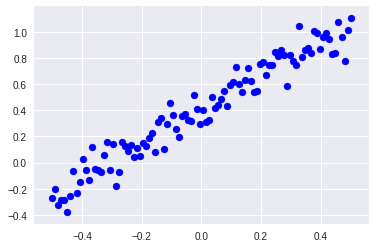

In [5]:
# first generate some observations
true_a = 1.3
true_b = 0.4
data_x = (np.arange(100) / 99.0 - .5).astype(np.float32) # Chainer assumes all the cpu computation is done in float32
data_y = (data_x * true_a + true_b + np.random.randn(*data_x.shape) * 0.1).astype(np.float32)
_ = plt.scatter(data_x, data_y, c='b')

Chainer provides an abstraction called `Link` that describe some computation and keeps track of parameters for it. For instance, a `Linear` link describes a linear map on input and keeps track of `w` and bias `b`.

In [6]:
model = L.Linear(in_size=1, out_size=1) # input is 1D data and output is also 1D data

# Chainer will randomly initialize `w` and `b` for us.
# we can take a look at their values
print("w:", model.W)
print("b:", model.b)

# model.W and model.b have type `chainer.Variable`, 
#   which is a wrapper around Numpy array
assert isinstance(model.W, chainer.Variable)

# operations that involve `chainer.Variable` will produce
#   `chainer.Variable` and this records the computation graph
var_result = model.W + 123 # some random computation
print("Operations on chainer.Variable: %s, type: %s" % (var_result, type(var_result)))

# the underlying numpy array can be accessed by `data` attribute
print("numpy arrays:", model.W.data, var_result.data)

('w:', variable W([[-2.68564606]]))
('b:', variable b([ 0.]))
Operations on chainer.Variable: variable([[ 120.31435394]]), type: <class 'chainer.variable.Variable'>
('numpy arrays:', array([[-2.68564606]], dtype=float32), array([[ 120.31435394]], dtype=float32))


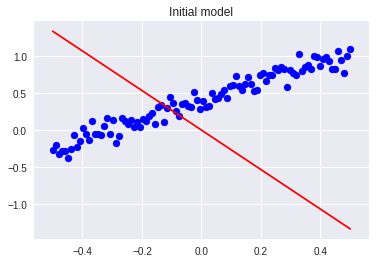

In [7]:
# A chainer link is a callable object. calling it performs the
#   forward computation. (in this case, it performs Wx + b)
model_y = model(data_x[:, None]) # chainer's link usually assumes input is [Batch Size, Input Dimension]
# `model_y` is a chainer variable so we use `.data` to access its numpy array for plotting

# we can plot the model's current fit in red. it should be terrible because we haven't trained it yet
_ = plt.plot(data_x, model_y.data[:,0], c='r')
_ = plt.scatter(data_x, data_y, c='b')
_ = plt.title("Initial model")

In [8]:
# now let's walk through how to perform forward computation
#  and use AD to get gradients

# first we clear the gradients that are stored in the model
model.cleargrads()
# as we have seen we can perform forward computation by calling the link
model_y = model(data_x[:, None])

# remember that `model_y` is a chainer variable. to operate on chainer variable
#    we will use functions from chainer.functions to operate on those objects.
loss = F.mean(F.square(model_y - data_y[:, None]))
# `loss` is a scalar chainer variable
assert isinstance(loss, chainer.Variable)
print("loss", loss)
# calculating gradients d loss /d params is as simple as
loss.backward()

# we can inspect the gradient of loss with respect to W
print("dloss/dW", model.W.grad)

('loss', variable(1.5272977352142334))
('dloss/dW', array([[-0.67883784]], dtype=float32))


Now that we know how to calculate gradients, we can code up a simple loop to perform gradient descent to train this model:

(Hint: if you run into weird problems, maybe the state has been messed up and you can try re-runing all the code blocks from the beginning)

('Itr', 0, 'loss:', variable(0.427589476108551))
('Itr', 25, 'loss:', variable(0.11692220717668533))
('Itr', 50, 'loss:', variable(0.05454133823513985))
('Itr', 75, 'loss:', variable(0.0280784722417593))


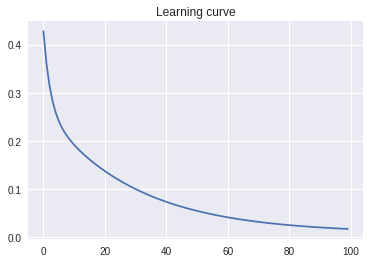

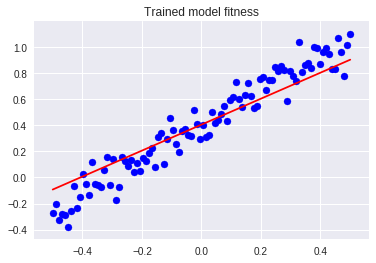

In [24]:
# now we can perform gradient descent to improve this model
model = L.Linear(in_size=1, out_size=1)
losses = []

for i in range(100):
    model.cleargrads()
    loss = F.mean(F.square(model(data_x[:, None]) - data_y[:, None]))
    losses.append(float(loss.data))
    ## *** YOUR CODE HERE TO PERFORM GRADIENT DESCENT ***
    ## Hint: you could access gradients with model.W.grad, model.b.grad
    ## Hint2: you could write data into a parameter with model.W.data[:] = some_numpy_array
    ## Hint3: if your model doesn't learn, remember to try different learning rates
    lr = 0.1 # learning rate
    model.cleargrads()
    loss.backward()
    model.W.data[:] -= model.W.grad[0] * lr
    model.b.data[:] -= model.b.grad[0] * lr
    
    if i % 25 == 0:
        print("Itr", i, "loss:", loss)
plt.plot(np.array(losses))
plt.title("Learning curve")
plt.figure()
plt.plot(data_x, model(data_x[:, None])[:,0].data, c='r')
plt.scatter(data_x, data_y, c='b')
_ = plt.title("Trained model fitness")


array([-0.22414903], dtype=float32)

## Train your first deep model

Now we have learned the basics of Chainer. We can use it to train a deep model to classify MNIST digits. We will train a model on the MNIST dataset because the dataset is small.

First we load the data and see what the images look like:

("train[i][0] is the ith image that's flattened, and has shape:", (784,))
("train[i][1] is the ith image's label, such as:", 3)


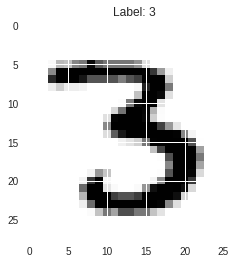

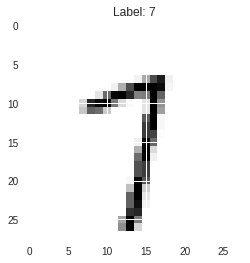

In [21]:
train, test = chainer.datasets.get_mnist()
# use train[data_point_index] to access data
print("train[i][0] is the ith image that's flattened, and has shape:", train[12][0].shape)
print("train[i][1] is the ith image's label, such as:", train[12][1])
# here we visualize two of them
plt.imshow(train[12][0].reshape([28, 28,]))
plt.title("Label: %s" % train[12][1])
plt.figure()
plt.imshow(train[42][0].reshape([28, 28,]))
_ = plt.title("Label: %s" % train[42][1])

Next we will provide some boilerplate code and train a linear classifier as an example:

In [22]:
def run(model, batchsize=16, num_epochs=2):
    
    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
        
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 300 == 0:
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

# try a simple linear model
run(L.Linear(None, 10))

loss: 2.32925891876; accuracy: 0.0
loss: 0.637445527315; accuracy: 0.08
loss: 0.480117873549; accuracy: 0.04
loss: 0.421319420338; accuracy: 0.16
loss: 0.374452891648; accuracy: 0.16
loss: 0.339015575051; accuracy: 0.2
loss: 0.332811718583; accuracy: 0.36
loss: 0.389967683554; accuracy: 0.16
loss: 0.355354978442; accuracy: 0.16
loss: 0.362367997468; accuracy: 0.24
loss: 0.306577712595; accuracy: 0.32
loss: 0.353270591199; accuracy: 0.16
loss: 0.386706850827; accuracy: 0.16
loss: 0.328302717209; accuracy: 0.2
loss: 0.330680179298; accuracy: 0.2
loss: 0.297317226529; accuracy: 0.32
loss: 0.306289359778; accuracy: 0.24
loss: 0.342978409827; accuracy: 0.28
loss: 0.29750328362; accuracy: 0.28
loss: 0.348949042261; accuracy: 0.24
loss: 0.311050440073; accuracy: 0.2
loss: 0.267931166291; accuracy: 0.08
loss: 0.25495399639; accuracy: 0.52
loss: 0.305251099467; accuracy: 0.2
loss: 0.222549476624; accuracy: 0.32
loss: 0.268471718431; accuracy: 0.28


Next we will try to improve performance by training an MLP instead. A partial implementation is provided for you to fill in:

In [23]:
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def __call__(self, x):
        # *** YOUR CODE HERE TO BUILD AN MLP W/ self.l1, self.l2, self.l3 ***
        # 
        # Hint: you should make use of non-linearities / activation functions
        #     https://docs.chainer.org/en/stable/reference/functions.html#activation-functions
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x
#         raise NotImplementedError()
run(MLP(200, 10))

loss: 2.19567322731; accuracy: 0.0
loss: 0.289126877189; accuracy: 0.12
loss: 0.230725547671; accuracy: 0.24
loss: 0.245554587245; accuracy: 0.28
loss: 0.187953667641; accuracy: 0.4
loss: 0.20777797401; accuracy: 0.36
loss: 0.151928565502; accuracy: 0.48
loss: 0.14529140085; accuracy: 0.6
loss: 0.116416935623; accuracy: 0.56
loss: 0.112564135492; accuracy: 0.44
loss: 0.151220483184; accuracy: 0.48
loss: 0.2010664922; accuracy: 0.28
loss: 0.0842502993345; accuracy: 0.6
loss: 0.0990357077122; accuracy: 0.68
loss: 0.0542347553372; accuracy: 0.72
loss: 0.153207380772; accuracy: 0.48
loss: 0.0910018110275; accuracy: 0.48
loss: 0.0606182068586; accuracy: 0.76
loss: 0.094375398159; accuracy: 0.72
loss: 0.0803616392612; accuracy: 0.68
loss: 0.137596744299; accuracy: 0.36
loss: 0.0812636685371; accuracy: 0.64
loss: 0.129164605439; accuracy: 0.52
loss: 0.0433241149783; accuracy: 0.8
loss: 0.0538192850351; accuracy: 0.68
loss: 0.0591419115663; accuracy: 0.76


Next you should try to implement logging test loss and see if the model is overfitting.

In [0]:
def better_run(model, batchsize=16, num_epochs=2):

    optimizer = chainer.optimizers.Adam() # we will use chainer's Adam implementation instead of writing our own gradient based optimization
    optimizer.setup(model)
    
    stats = defaultdict(lambda: deque(maxlen=25))
    for epoch in range(num_epochs):
        train_iter = chainer.iterators.SerialIterator(train, batchsize, repeat=False, shuffle=True)
        for itr, batch in enumerate(train_iter):
            xs = np.concatenate([datum[0][None, :] for datum in batch])
            ys = np.array([datum[1] for datum in batch])

            logits = model(xs)

            loss = F.softmax_cross_entropy(logits, ys)
            model.cleargrads()
            loss.backward()
            optimizer.update()
            
            # calculate stats
            stats["loss"].append(float(loss.data))
            stats["accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
            if itr % 30 == 0:
                test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
                # *** YOUR CODE implement logging of stats on test set ***
                for batch_test in test_iter:
                    xs = np.concatenate([datum[0][None, :] for datum in batch_test])
                    ys = np.array([datum[1] for datum in batch_test])

                    logits = model(xs)

                    loss = F.softmax_cross_entropy(logits, ys)
                    # no need to learn, when we are testing
                    # calculate stats
                    stats["val_loss"].append(float(loss.data))
                    stats["val_accuracy"].append(float((logits.data.argmax(1) == ys).sum() / batchsize))
                    
                print("; ".join("%s: %s" % (k, np.mean(vs)) for k, vs in stats.items()))

better_run(MLP(200, 10))

loss: 2.38229012489; val_accuracy: 0.0; val_loss: 2.29367769241; accuracy: 0.0
loss: 1.55391245842; val_accuracy: 0.0; val_loss: 1.13345803261; accuracy: 0.0
loss: 0.646526403427; val_accuracy: 0.0; val_loss: 0.822305475473; accuracy: 0.08
loss: 0.527407506108; val_accuracy: 0.0; val_loss: 0.691670941114; accuracy: 0.0
loss: 0.466817269325; val_accuracy: 0.08; val_loss: 0.612925790548; accuracy: 0.04
loss: 0.393106015325; val_accuracy: 0.04; val_loss: 0.580229463577; accuracy: 0.04
loss: 0.353550501466; val_accuracy: 0.0; val_loss: 0.639054588675; accuracy: 0.16
loss: 0.325949620903; val_accuracy: 0.0; val_loss: 0.54268496573; accuracy: 0.16
loss: 0.493765832782; val_accuracy: 0.04; val_loss: 0.598064358234; accuracy: 0.08
loss: 0.441802020669; val_accuracy: 0.08; val_loss: 0.474574801922; accuracy: 0.12
loss: 0.315273371339; val_accuracy: 0.16; val_loss: 0.465327720046; accuracy: 0.24
loss: 0.358024782836; val_accuracy: 0.08; val_loss: 0.472458402514; accuracy: 0.28
loss: 0.3228305315

Try different variants!

- Does using a ConvNet improve performance (reduce overfitting?)
- Try changing the learning rate and observe the effect
- Does the model train if you give it correlated gradients? (consecutively sample many batches of "1", then many batches of "2", ... etc